In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, SelectPercentile, f_classif
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA

trius = np.load('trius.npy')
labels = np.load('labels.npy')
seed = 2048
np.random.seed(seed)
X = trius
y = labels

X = MinMaxScaler().fit_transform(X)

selector = VarianceThreshold(0.03)
selector.fit(X)
X = selector.transform(X)
print(X.shape)

selector = SelectKBest(chi2, k=2048)
X = selector.fit_transform(X, y)
print(X.shape)

etc = GradientBoostingClassifier().fit(X, y)
model = SelectFromModel(etc, prefit=True)
X = model.transform(X)
print(X.shape)

#X = PCA(n_components=128).fit_transform(X)
print(X.shape)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
print('样本集大小：',X.shape,y.shape)
print('训练集大小：',x_train.shape,y_train.shape)  # 训练集样本大小
print('测试集大小：',x_test.shape,y_test.shape)  # 测试集样本大小

seed = 2019
F = X
l = y

clf = SVC(kernel='rbf', C=100, gamma=1e-3)
scores = cross_val_score(clf, X, y, cv=10)
print(np.mean(scores), np.std(scores)*2)

mlp = MLPClassifier((256, 16), solver='adam', activation='relu', max_iter=800)
scores = cross_val_score(mlp, X, y, cv=10)
print(np.mean(scores), np.std(scores)*2)

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hasee007\AppData\Roaming\Python\Py

(252, 3772)
(252, 2048)
(252, 146)
(252, 146)
样本集大小： (252, 146) (252,)
训练集大小： (226, 146) (226,)
测试集大小： (26, 146) (26,)
0.8210384615384616 0.13595163167040755
0.8170384615384616 0.14395267549116647


In [4]:
# Visualize decoder setting
# Parameters
LR = 0.01
training_epoch = 400
batch_size = 128
display_step = 20

# Network Parameters
n_input = 146

# hidden layer settings
n_hidden_1 = 128  # 1st layer num features
n_hidden_2 = 64 # 2nd layer num features
n_hidden_3 = 16  # 3rd layer num features

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("int64", [None,])


weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'encoder_h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),

    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),

    'classifier_h1': tf.Variable(tf.random_normal([n_hidden_3, 2])),
}
bias = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([n_hidden_3])),

    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
    
    'classifier_b1': tf.Variable(tf.random_normal([2])),
}


# Build the encoder
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   bias['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   bias['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                   bias['encoder_b3']))
    return layer_3


# Build the decoder
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   bias['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   bias['decoder_b2']))
    return layer_2


# Build the classifier
def classifier(x):
    layer_1 = tf.nn.softmax(tf.add(tf.matmul(x, weights['classifier_h1']), bias['classifier_b1']))
    return layer_1

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)
classifier_op = classifier(encoder_op)

# Prediction
y_pred = decoder_op
# Labels are the input data
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(LR).minimize(loss)

clf_y_pred = classifier_op
clf_y_true = Y
loss_clf = tf.reduce_mean(-tf.reduce_sum(tf.one_hot(clf_y_true, depth=2) * tf.log(clf_y_pred), reduction_indices=[1]))
acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(clf_y_pred, 1), clf_y_true), tf.float32))
optimizer_clf = tf.train.AdamOptimizer(LR).minimize(loss_clf)

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
sess = tf.Session()
sess.run(init)
total_batch = int(len(x_train) / batch_size)

In [5]:
# Training cycle
for epoch in range(training_epoch * 2):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = x_train[i * batch_size : (i+1) * batch_size] if i < total_batch else x_train[i * batch_size : len(x_train)]
        # Run 
        _, c = sess.run([optimizer, loss], feed_dict={X: batch_xs})
    if epoch % display_step == 0:
        print("Iteration: %04d " % (epoch), "loss=", "{:.9f}".format(c))

Iteration: 0000  loss= 0.264064819
Iteration: 0020  loss= 0.096511424
Iteration: 0040  loss= 0.067504972
Iteration: 0060  loss= 0.052858248
Iteration: 0080  loss= 0.043186229
Iteration: 0100  loss= 0.038280986
Iteration: 0120  loss= 0.032618724
Iteration: 0140  loss= 0.030526495
Iteration: 0160  loss= 0.027235774
Iteration: 0180  loss= 0.026499588
Iteration: 0200  loss= 0.025936624
Iteration: 0220  loss= 0.025277462
Iteration: 0240  loss= 0.024714110
Iteration: 0260  loss= 0.024145849
Iteration: 0280  loss= 0.023655055
Iteration: 0300  loss= 0.023205372
Iteration: 0320  loss= 0.022647204
Iteration: 0340  loss= 0.022177465
Iteration: 0360  loss= 0.021584518
Iteration: 0380  loss= 0.021210220
Iteration: 0400  loss= 0.020806367
Iteration: 0420  loss= 0.020469340
Iteration: 0440  loss= 0.020122910
Iteration: 0460  loss= 0.019752761
Iteration: 0480  loss= 0.019574793
Iteration: 0500  loss= 0.019093975
Iteration: 0520  loss= 0.019012777
Iteration: 0540  loss= 0.018509457
Iteration: 0560  los

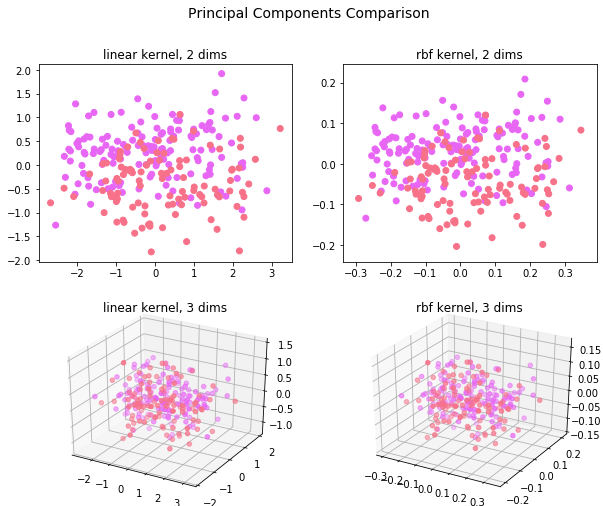

In [7]:
from mlens.visualization import pca_comp_plot
test_code = sess.run(encoder_op, feed_dict={X: F})
test_decode = sess.run(decoder_op, feed_dict={X: F})
pca_comp_plot(F, l)
plt.show()

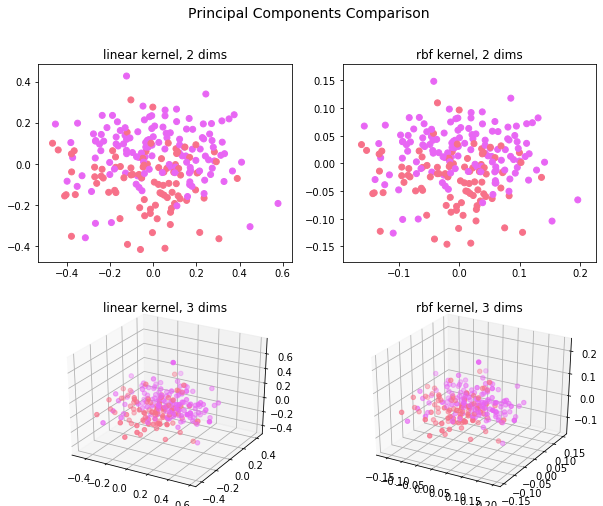

In [5]:
code = sess.run(encoder_op, feed_dict={X: x_train})
test_decode = sess.run(decoder_op, feed_dict={X: x_train})
pca_comp_plot(code, y_train)
plt.show()

In [8]:
print('Triang CLF')
for epoch in range(training_epoch):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = x_train[i * batch_size : (i+1) * batch_size] if i < total_batch else x_train[i * batch_size : len(x_train)]
        batch_ys = y_train[i * batch_size : (i+1) * batch_size] if i < total_batch else y_train[i * batch_size : len(y_train)]
        # Run 
        _, c = sess.run([optimizer_clf, loss_clf], feed_dict={X: batch_xs, Y:batch_ys})
    if epoch % display_step == 0:
        a = sess.run(acc, feed_dict={X: x_test, Y: y_test})
        l = sess.run(loss, feed_dict={X: x_test})
        print("Iteration: %04d " % (epoch), "loss=", "{:.9f} acc {:.9f} decode loss {:.9f}".format(c, a, l))

Triang CLF
Iteration: 0000  loss= 1.075841904 acc 0.538461566 decode loss 0.057231657
Iteration: 0020  loss= 0.214460433 acc 0.846153855 decode loss 0.118208140
Iteration: 0040  loss= 0.044325091 acc 0.884615362 decode loss 0.147400916
Iteration: 0060  loss= 0.007303993 acc 0.884615362 decode loss 0.175601125
Iteration: 0080  loss= 0.002390716 acc 0.807692289 decode loss 0.173093468
Iteration: 0100  loss= 0.001386117 acc 0.846153855 decode loss 0.175813660
Iteration: 0120  loss= 0.000979796 acc 0.846153855 decode loss 0.178475797
Iteration: 0140  loss= 0.000751306 acc 0.807692289 decode loss 0.179941341
Iteration: 0160  loss= 0.000601072 acc 0.807692289 decode loss 0.181656912
Iteration: 0180  loss= 0.000495963 acc 0.807692289 decode loss 0.183853567
Iteration: 0200  loss= 0.000419542 acc 0.807692289 decode loss 0.186215177
Iteration: 0220  loss= 0.000362196 acc 0.807692289 decode loss 0.188154295
Iteration: 0240  loss= 0.000317905 acc 0.807692289 decode loss 0.189535722
Iteration: 026

In [7]:
[256, 128, 8, 0.846]
[128, 64, 16, 0.923]

[128, 64, 16, 0.923]

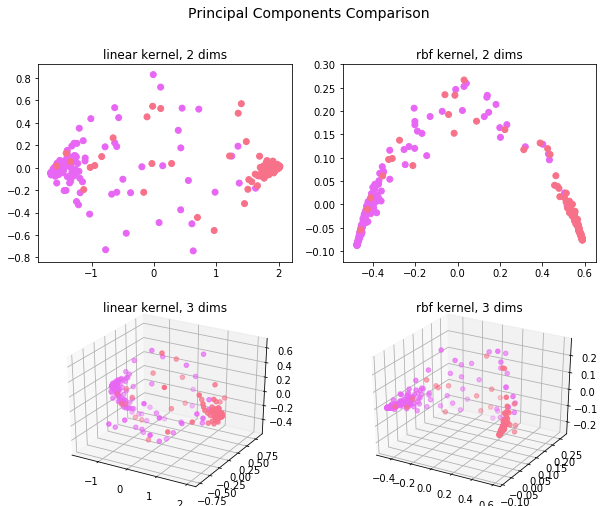

In [10]:
code = sess.run(encoder_op, feed_dict={X: F})
decode = sess.run(decoder_op, feed_dict={X: F})
pca_comp_plot(code, y)
plt.show()

In [14]:
np.save('code.npy', code)